In [1]:
import pandas as pd
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from IPython.display import display
import numpy as np
import re
import warnings
from typing import List, Iterable
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

In [43]:
pio.renderers.default='plotly_mimetype'

In [3]:
test_patent = pd.read_csv('fda_orange_book_files/patent.txt', sep = "~", header = 0)
test_product = pd.read_csv('fda_orange_book_files/products.txt', sep = "~", header = 0)
test_exclusivity = pd.read_csv('fda_orange_book_files/exclusivity.txt', sep = "~", header = 0)

In [4]:
test_patent.columns = test_patent.columns.str.strip().str.upper()
test_product.columns = test_product.columns.str.strip().str.upper()
test_exclusivity.columns = test_exclusivity.columns.str.strip().str.upper()

In [5]:
orange_df = test_product.merge(
    test_patent, on = ['APPL_NO', 'PRODUCT_NO'],
    how = 'left',
    validate = '1:m',
    indicator = False
)
orange_df = orange_df.drop(columns = ['APPL_TYPE_y'])

In [6]:
orange_df.rename(columns = {'APPL_TYPE_x': 'APPL_TYPE'}, inplace = True)
orange_df[orange_df['TRADE_NAME'] == 'CRESTOR']

,INGREDIENT,DF;ROUTE,TRADE_NAME,APPLICANT,STRENGTH,APPL_TYPE,APPL_NO,PRODUCT_NO,TE_CODE,APPROVAL_DATE,...,RS,TYPE,APPLICANT_FULL_NAME,PATENT_NO,PATENT_EXPIRE_DATE_TEXT,DRUG_SUBSTANCE_FLAG,DRUG_PRODUCT_FLAG,PATENT_USE_CODE,DELIST_FLAG,SUBMISSION_DATE
44677,ROSUVASTATIN CALCIUM,TABLET;ORAL,CRESTOR,ASTRAZENECA,EQ 5MG BASE,N,21366,2,AB,"Aug 12, 2003",...,No,RX,ASTRAZENECA UK LTD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44678,ROSUVASTATIN CALCIUM,TABLET;ORAL,CRESTOR,ASTRAZENECA,EQ 10MG BASE,N,21366,3,AB,"Aug 12, 2003",...,No,RX,ASTRAZENECA UK LTD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44679,ROSUVASTATIN CALCIUM,TABLET;ORAL,CRESTOR,ASTRAZENECA,EQ 20MG BASE,N,21366,4,AB,"Aug 12, 2003",...,No,RX,ASTRAZENECA UK LTD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44680,ROSUVASTATIN CALCIUM,TABLET;ORAL,CRESTOR,ASTRAZENECA,EQ 40MG BASE,N,21366,5,AB,"Aug 12, 2003",...,Yes,RX,ASTRAZENECA UK LTD,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def parse_spending_ytd_excel(path: Path | str) -> pd.DataFrame:
    path = Path(path)
    xls = pd.ExcelFile(path)
    target_sheets = [s for s in xls.sheet_names if s.startswith("Spending & Utilization YTD") or s.startswith("Spending Utilization YTD")]
    if not target_sheets:
        raise ValueError(f"No 'Spending & Utilization YTD' sheet in: {path.name}")
    sheet = target_sheets[0]

    # Read raw (no header); we’ll discover the header row
    df = pd.read_excel(path, sheet_name=sheet, header=None)

    # Header row: where col0 == "Brand Name"
    hdr_idx = df.index[df.iloc[:, 0].astype(str).str.fullmatch("Brand Name")]
    if hdr_idx.empty:
        raise ValueError(f"Couldn't find header row in: {path.name} / {sheet}")
    h = int(hdr_idx[0])

    # Year labels live on the row above header: "Calendar Year 2016" marks block starts
    year_row = h - 1
    year_starts = {}
    for j, val in enumerate(df.iloc[year_row]):
        if pd.isna(val):
            continue
        m = re.search(r"Calendar Year\s+(\d{4})", str(val))
        if m:
            year_starts[j] = int(m.group(1))
    if not year_starts:
        raise ValueError(f"No 'Calendar Year ####' labels found in: {path.name} / {sheet}")

    # ID columns precede the first year block (observed to be the first 3 cols)
    id_cols = list(range(0, 3))
    id_names = df.iloc[h, id_cols].tolist()

    # Build blocks [start_col:end_col] for each year
    sorted_starts = sorted(year_starts.items())  # [(start_col, year), ...]
    blocks: List[tuple[int, list[int], list[str]]] = []
    for k, (col_start, year) in enumerate(sorted_starts):
        col_end = sorted_starts[k + 1][0] - 1 if k + 1 < len(sorted_starts) else (df.shape[1] - 1)
        block_cols = list(range(col_start, col_end + 1))
        metric_names = df.iloc[h, block_cols].tolist()
        blocks.append((year, block_cols, metric_names))

    # Data begins under the header row
    data = df.iloc[h + 1:].reset_index(drop=True)
    base = data.iloc[:, id_cols]
    base.columns = id_names

    out_frames = []
    for year, block_cols, metric_names in blocks:
        sub = data.iloc[:, block_cols].copy()
        sub.columns = metric_names
        sub = pd.concat([base, sub], axis=1)
        sub["Calendar Year"] = year
        out_frames.append(sub)

    tidy = pd.concat(out_frames, ignore_index=True)

    # Clean up headers & rows
    tidy.columns = [str(c).replace("\n", " ").strip() for c in tidy.columns]
    tidy = tidy[tidy[id_names[0]].notna()].reset_index(drop=True)

    # Convert numeric-looking columns (leave IDs + Calendar Year)
    for col in tidy.columns:
        if col not in id_names and col != "Calendar Year":
            tidy[col] = pd.to_numeric(tidy[col], errors="ignore")

    tidy["Source File"] = path.name
    tidy["Source Sheet"] = sheet
    return tidy



def concat_spending_ytd(paths_or_dir: Iterable[str | Path] | str | Path) -> pd.DataFrame:
    if isinstance(paths_or_dir, (str, Path)):
        root = Path(paths_or_dir)
        if root.is_dir():
            files = sorted(root.rglob("*.xlsx"))
        else:
            files = [root]
    else:
        files = [Path(p) for p in paths_or_dir]

    frames = []
    for f in files:
        try:
            frames.append(parse_spending_ytd_excel(f))
        except Exception as e:
            # Skip bad/noisy files but tell you which one failed
            print(f"[WARN] Skipping {f.name}: {e}")

    if not frames:
        raise ValueError("No valid workbooks found to parse.")

    df_all = pd.concat(frames, ignore_index=True)
    # Optional: enforce column order (IDs → metrics → Calendar Year → provenance)
    first_three = ["Brand Name", "Generic Name", "Number of Manufacturers"]
    rest = [c for c in df_all.columns if c not in (first_three + ["Calendar Year", "Source File", "Source Sheet"])]
    ordered = first_three + rest + ["Calendar Year", "Source File", "Source Sheet"]
    return df_all.loc[:, ordered]



def get_path_orange_book():
    return Path('/home/mike/school_git/DAT_490/fda_orange_book_files/')

def get_path_spending_by_drug():
    return Path('/home/mike/school_git/DAT_490/medicare_partd_spending_by_drug/2023/')

In [8]:
warnings.filterwarnings('ignore', category = FutureWarning)
drug_spending_df = concat_spending_ytd(get_path_spending_by_drug())
drug_spending_df_renamed = drug_spending_df.rename(columns = {'Brand Name': 'Brnd_Name', 'Generic Name': 'Gnrc_Name'})

In [9]:
cms_drug_spending = drug_spending_df_renamed

In [10]:
cms_drug_spending.columns

Index(['Brnd_Name', 'Gnrc_Name', 'Number of Manufacturers', 'Total Spending',
       'Total Dosage Units', 'Total Claims', 'Total Beneficiaries',
       'Average Spending Per Dosage Unit (Weighted)',
       'Average Spending Per Claim', 'Average Spending Per Beneficiary',
       'Change in Average Spending Per Dosage Unit (2015-2016)',
       'Annual Growth Rate in Average Spending Per Dosage Unit (2012-2016)',
       'Total  Claims',
       'Change in Average Spending Per Dosage Unit (2016-2017)',
       'Annual Growth Rate in Average Spending Per Dosage Unit (2013-2017)',
       'Total  Beneficiaries', 'Average  Spending Per Claim',
       'Average  Spending Per Beneficiary', 'Outlier  Flag',
       'Change in Average Spending Per Dosage Unit (2017-2018)',
       'Annual Growth Rate in Average Spending Per Dosage Unit (2014-2018)',
       'Change in Average Spending Per Dosage Unit (2018-2019)',
       'Annual Growth Rate in Average Spending Per Dosage Unit (2015-2019)',
       'Chan

In [11]:
def fetch_medicare_prescribers_csv(root:Path) -> dict:
    dataframe_dict = {}
    for file in root.rglob('*.csv'):
        # df = pd.read_csv(file, low_memory = False)
        df_name = file.parent.name
        dataframe_dict[df_name] = pd.read_csv(file, low_memory = False)
        sorted_dict = dict(sorted(dataframe_dict.items()))
        # df_name['Year'] = file.parent.name

    return sorted_dict

def get_path():
    return Path('/home/mike/school_git/DAT_490/Medicare_Part_D_Prescribers_by_Geography_and_Drug/')

def merge_dfs(func) -> pd.DataFrame:
    year_list = []
    total_rows = 0

    for year, df in func.items():
        df = df.copy()
        df['year'] = int(year)

        year_list.append(df)
        total_rows += len(df)

    combined_df = pd.concat(year_list, axis = 0, ignore_index = True)
    return combined_df


dataframes = merge_dfs(fetch_medicare_prescribers_csv(get_path()))
# dataframes = fetch_medicare_prescribers_csv(get_path())
display(dataframes.shape)
display(dataframes.head())

(800687, 23)

,Prscrbr_Geo_Lvl,Prscrbr_Geo_Cd,Prscrbr_Geo_Desc,Brnd_Name,Gnrc_Name,Tot_Prscrbrs,Tot_Clms,Tot_30day_Fills,Tot_Drug_Cst,Tot_Benes,...,GE65_Tot_Drug_Cst,GE65_Bene_Sprsn_Flag,GE65_Tot_Benes,LIS_Bene_Cst_Shr,NonLIS_Bene_Cst_Shr,Opioid_Drug_Flag,Opioid_LA_Drug_Flag,Antbtc_Drug_Flag,Antpsyct_Drug_Flag,year
0,National,NaN,National,1st Tier Unifine Pentips,"Pen Needle, Diabetic",2533,8595,13856.7,217938.04,3025.0,...,168913.53,NaN,2352.0,9105.64,46037.22,N,N,N,N,2017
1,National,NaN,National,1st Tier Unifine Pentips Plus,"Pen Needle, Diabetic",4260,15390,27140.8,401823.61,5962.0,...,307078.48,NaN,4565.0,15088.85,82715.46,N,N,N,N,2017
2,National,NaN,National,Abacavir,Abacavir Sulfate,5551,60886,67405.4,16806136.08,8084.0,...,6335450.03,NaN,2987.0,42817.00,373173.14,N,N,N,N,2017
3,National,NaN,National,Abacavir-Lamivudine,Abacavir Sulfate/Lamivudine,5379,80632,85077.2,51241279.63,10460.0,...,19178361.28,NaN,3758.0,83746.83,1124846.10,N,N,N,N,2017
4,National,NaN,National,Abacavir-Lamivudine-Zidovudine,Abacavir/Lamivudine/Zidovudine,995,7451,7999.3,10158493.71,971.0,...,4211356.60,NaN,381.0,13361.70,302612.50,N,N,N,N,2017


In [12]:
dataframes_copy = dataframes.copy()
dataframes_copy = dataframes_copy[dataframes_copy['Tot_Clms'] > 0].copy()

In [13]:
dataframes_copy['drug_name'] = dataframes_copy['Gnrc_Name'].fillna(dataframes_copy['Brnd_Name'])
dataframes_copy['cost_per_claim'] = dataframes_copy['Tot_Drug_Cst'] / dataframes_copy['Tot_Clms']

In [14]:
WINDOW_YEARS = 3          # consider drops within [first ANDA year, ANDA year + WINDOW_YEARS]
DROP_THRESHOLD = 0.20     # >=30% YoY drop
TOP_N = 25                # how many candidates to peek at


In [15]:
# Assumes you already have: orange_df with these columns:
# ['INGREDIENT','DF;ROUTE','TRADE_NAME','APPLICANT','STRENGTH','APPL_TYPE','APPL_NO',
#  'PRODUCT_NO','TE_CODE','APPROVAL_DATE','RLD','RS','TYPE','APPLICANT_FULL_NAME']

orange_df = orange_df.copy()

# Parse approval date to year
orange_df['APPROVAL_DATE'] = pd.to_datetime(orange_df['APPROVAL_DATE'], errors='coerce')
orange_df['approval_year'] = orange_df['APPROVAL_DATE'].dt.year

# First ANDA (APPL_TYPE == 'A') year per INGREDIENT
first_anda = (
    orange_df.loc[orange_df['APPL_TYPE'].eq('A')]
             .dropna(subset=['approval_year'])
             .groupby('INGREDIENT', as_index=False)['approval_year']
             .min()
             .rename(columns={'approval_year': 'first_anda_year'})
)

# Simple brand→ingredient map via TRADE_NAME seen in Orange Book
brand_to_ing = (
    orange_df[['TRADE_NAME','INGREDIENT']]
      .dropna()
      .drop_duplicates()
      .rename(columns={'TRADE_NAME':'Brnd_Name'})
)


In [16]:
# --- NEW: manufacturer roster by ingredient (from Orange Book) ---
mfr_roster = (
    orange_df[['INGREDIENT','APPL_TYPE','APPLICANT_FULL_NAME']]
    .dropna()
    .drop_duplicates()
    .rename(columns={'APPL_TYPE':'appl_type','APPLICANT_FULL_NAME':'manufacturer'})
)

# --- NEW: simple helper to list manufacturers for a given brand ---
def manufacturers_for_brand(brand_name):
    ing = brand_to_ing.loc[brand_to_ing['Brnd_Name'].eq(brand_name), 'INGREDIENT']
    if ing.empty:
        return pd.DataFrame(columns=['INGREDIENT','appl_type','manufacturer'])
    ing = ing.iloc[0]
    out = mfr_roster.loc[mfr_roster['INGREDIENT'].eq(ing)].copy()
    out = out.sort_values(['appl_type','manufacturer']).reset_index(drop=True)
    return out

# Example:
manufacturers_for_brand("Crestor")

,INGREDIENT,appl_type,manufacturer


In [17]:
display(first_anda)
display(brand_to_ing)

,INGREDIENT,first_anda_year
0,ABACAVIR SULFATE,2012.0
1,ABACAVIR SULFATE; LAMIVUDINE,2016.0
2,ABACAVIR SULFATE; LAMIVUDINE; ZIDOVUDINE,2013.0
3,ABIRATERONE ACETATE,2018.0
4,ACAMPROSATE CALCIUM,2013.0
...,...,...
1356,ZIPRASIDONE MESYLATE,2019.0
1357,ZOLEDRONIC ACID,2013.0
1358,ZOLMITRIPTAN,2013.0
1359,ZOLPIDEM TARTRATE,2007.0


,Brnd_Name,INGREDIENT
0,BUDESONIDE,BUDESONIDE
1,UCERIS,BUDESONIDE
2,AMZEEQ,MINOCYCLINE HYDROCHLORIDE
14,AZELAIC ACID,AZELAIC ACID
15,BETAMETHASONE VALERATE,BETAMETHASONE VALERATE
...,...,...
65191,VAGIFEM,ESTRADIOL
65194,GENAPAX,GENTIAN VIOLET
65195,MONISTAT 5,MICONAZOLE NITRATE
65200,FENTANYL,FENTANYL CITRATE


In [18]:
# Assumes cms_df with columns shown, including 'Brnd_Name' and 'Calendar Year' and 'Total Spending'
cms_df = cms_drug_spending.copy()

if 'Total Claims' in cms_df.columns:
    cms_df['Total Claims'] = cms_df['Total Claims'].fillna(cms_df['Total Claims'])


# Normalize year and spending
cms_df['Calendar Year'] = pd.to_numeric(cms_df['Calendar Year'], errors='coerce')
cms_df['Total Spending'] = pd.to_numeric(cms_df['Total Spending'], errors='coerce')
cms_df['Total Dosage Units'] = pd.to_numeric(cms_df['Total Dosage Units'], errors='coerce')
cms_df['Total Claims'] = pd.to_numeric(cms_df['Total Claims'], errors='coerce')
cms_df['Average Spending Per Claim'] = pd.to_numeric(cms_df['Average Spending Per Claim'], errors='coerce')

def build_brand_year_spend(cms_df):
    # normalize duplicate claims col
    if 'Total  Claims' in cms_df.columns:
        cms_df = cms_df.copy()
        cms_df['Total Claims'] = cms_df['Total Claims'].fillna(cms_df['Total  Claims'])

    out = (
        cms_df
        .groupby(['Brnd_Name', 'Calendar Year'])
        .apply(lambda g: pd.Series({
            'spend': g['Total Spending'].sum(),
            'dosage_units': g['Total Dosage Units'].sum(),
            'claims': pd.to_numeric(g['Total Claims'], errors = 'coerce').sum(),
            # weighted avg spending per claim
            'avg_spend_per_claim': (
                (pd.to_numeric(g['Average Spending Per Claim'], errors = 'coerce').fillna(0) * pd.to_numeric(g['Total Claims'], errors = 'coerce').fillna(0)).sum()
                / pd.to_numeric(g['Total Claims'], errors = 'coerce').fillna(0).sum()
            ) if pd.to_numeric(g['Total Claims'], errors = 'coerce').fillna(0).sum() else None
        }))
        .reset_index()                                  # <-- IMPORTANT
        .rename(columns={'Calendar Year': 'year'})      # <-- now this works
    )

    out['year'] = out['year'].astype(int)
    return out

# usage:
brand_year_spend = build_brand_year_spend(cms_df)


In [19]:
# Merge brand→ingredient, then ingredient→first ANDA year
brand_spend_with_ing = brand_year_spend.merge(brand_to_ing, on='Brnd_Name', how='left')
brand_spend_with_anda = brand_spend_with_ing.merge(first_anda, on='INGREDIENT', how='left')

In [20]:
# YoY by brand (within each brand)
brand_spend_with_anda = brand_spend_with_anda.sort_values(['Brnd_Name','year'])
brand_spend_with_anda['spend_prev'] = (
    brand_spend_with_anda.groupby('Brnd_Name')['spend'].shift(1)
)
brand_spend_with_anda['drop_pct'] = (
    ((brand_spend_with_anda['spend'] - brand_spend_with_anda['spend_prev'])
    / abs(brand_spend_with_anda['spend_prev'])) * 100
)

# Filter: drop at least DROP_THRESHOLD (negative), within ANDA window
candidates = brand_spend_with_anda[
    (brand_spend_with_anda['first_anda_year'].notna()) &
    (brand_spend_with_anda['spend_prev'].notna()) &
    (brand_spend_with_anda['drop_pct'] <= -DROP_THRESHOLD) &
    (brand_spend_with_anda['year'] >= brand_spend_with_anda['first_anda_year']) &
    (brand_spend_with_anda['year'] <= brand_spend_with_anda['first_anda_year'] + WINDOW_YEARS)
].copy()

# Keep just the essentials
cliffs_simple = candidates[['Brnd_Name','INGREDIENT','first_anda_year','year','spend_prev','spend','drop_pct']]\
                    .sort_values(['drop_pct'])\
                    .reset_index(drop=True)

cliffs_simple.head(TOP_N)


,Brnd_Name,INGREDIENT,first_anda_year,year,spend_prev,spend,drop_pct


In [21]:
brand_spend_with_anda[brand_spend_with_anda['Brnd_Name'].isin(['Atorvastatin Calcium'])]

,Brnd_Name,year,spend,dosage_units,claims,avg_spend_per_claim,INGREDIENT,first_anda_year,spend_prev,drop_pct
3904,Atorvastatin Calcium,2013,7.560298e+08,1.132053e+09,22742483.0,33.243061,NaN,NaN,NaN,NaN
3905,Atorvastatin Calcium,2014,1.483891e+09,3.361234e+09,64648724.0,11.449354,NaN,NaN,7.560298e+08,96.274098
3906,Atorvastatin Calcium,2015,2.135002e+09,6.233353e+09,115739950.0,6.149182,NaN,NaN,1.483891e+09,43.878695
3907,Atorvastatin Calcium,2016,3.028025e+09,9.965112e+09,177904521.0,4.255282,NaN,NaN,2.135002e+09,41.827721
3908,Atorvastatin Calcium,2017,4.005833e+09,1.426857e+10,240456582.0,3.207699,NaN,NaN,3.028025e+09,32.291919
3909,Atorvastatin Calcium,2018,4.404686e+09,1.639071e+10,258695258.0,0.000000,NaN,NaN,4.005833e+09,9.956813
3910,Atorvastatin Calcium,2019,4.517622e+09,1.792733e+10,269216190.0,0.000000,NaN,NaN,4.404686e+09,2.563998
3911,Atorvastatin Calcium,2020,3.343854e+09,1.598839e+10,230156987.0,0.000000,NaN,NaN,4.517622e+09,-25.981998
3912,Atorvastatin Calcium,2021,2.508414e+09,1.301532e+10,183288865.0,0.000000,NaN,NaN,3.343854e+09,-24.984342
3913,Atorvastatin Calcium,2022,1.693556e+09,9.308673e+09,129594440.0,0.000000,NaN,NaN,2.508414e+09,-32.484973


In [22]:
# Optional quick look at the biggest drops anytime (not just near ANDA)
biggest_drops_any_year = (
    brand_spend_with_anda
    .dropna(subset=['drop_pct'])
    .sort_values('drop_pct')
    [['Brnd_Name','INGREDIENT','year','spend_prev','spend','drop_pct','first_anda_year']]
)
display(biggest_drops_any_year[biggest_drops_any_year['drop_pct'] < 2].head(25))


,Brnd_Name,INGREDIENT,year,spend_prev,spend,drop_pct,first_anda_year
12142,Demerol*,NaN,2019,96090.23,0.0,-100.0,NaN
32910,Nityr,NaN,2022,479782.14,0.0,-100.0,NaN
42524,Saxenda,NaN,2018,13671.00,0.0,-100.0,NaN
39295,Promethazine Vc,NaN,2020,71742.68,0.0,-100.0,NaN
39310,Promethazine Vc-Codeine,NaN,2019,3902.89,0.0,-100.0,NaN
42657,Select-Ob + DHA,NaN,2013,10158.76,0.0,-100.0,NaN
36011,Parlodel,NaN,2015,19420.90,0.0,-100.0,NaN
51498,Vitafol-Ob+DHA,NaN,2013,2858.60,0.0,-100.0,NaN
51482,Vitafol-Ob,NaN,2013,4853.11,0.0,-100.0,NaN
47078,Tobi,NaN,2019,351405.81,0.0,-100.0,NaN


In [23]:
drugs_by_state = (
    dataframes_copy.groupby(['Prscrbr_Geo_Desc', 'drug_name', 'Prscrbr_Geo_Cd', 'year'], as_index = False)
    .agg(cost_per_claim = ('cost_per_claim', 'mean'),
         clms = ('Tot_Clms', 'sum'),
         cost = ('Tot_Drug_Cst', 'sum'))
)
idx = drugs_by_state.groupby('Prscrbr_Geo_Desc')['cost_per_claim'].idxmax()
top_cost_by_state = drugs_by_state.loc[idx, ['Prscrbr_Geo_Desc', 'drug_name', 'cost_per_claim']].rename(
    columns = {'drug_name': 'top_drug', 'cost_per_claim': 'top_drug_cost_per_claim'}
)

state_numeric = (
    dataframes_copy.groupby(['Prscrbr_Geo_Desc', 'Prscrbr_Geo_Cd'], as_index = False)
    .agg(avg_cost_per_claim = ('cost_per_claim', 'mean'),
         median_cost_per_claim = ('cost_per_claim', 'median'),
         total_claims = ('Tot_Clms', 'sum'),
         total_spend = ('Tot_Drug_Cst', 'sum'),
         unique_drugs = ('drug_name', 'nunique'))
).merge(top_cost_by_state, on = 'Prscrbr_Geo_Desc', how = 'left')

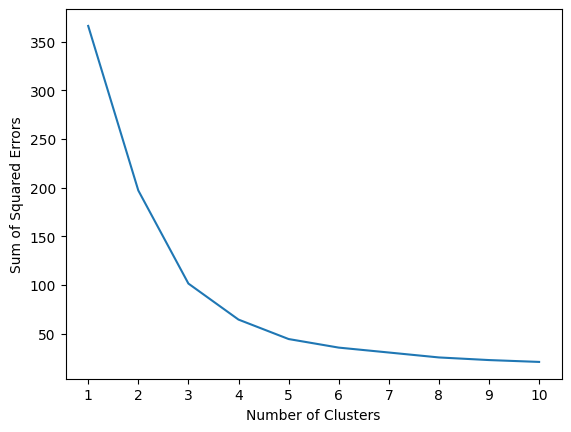

['Prscrbr_Geo_Cd', 'avg_cost_per_claim', 'median_cost_per_claim', 'total_claims', 'total_spend', 'unique_drugs', 'top_drug_cost_per_claim']


In [24]:
# KMeans clustering and finding the optimal cluster number
num_cols = [c for c in state_numeric.columns if c not in ['Prscrbr_Geo_Desc','top_drug']]
X = state_numeric[num_cols].select_dtypes(include=[np.number]).to_numpy()
Xs = StandardScaler().fit_transform(X)

sum_squared_errors = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 10, random_state = 42)
    kmeans.fit(Xs)
    sum_squared_errors.append(kmeans.inertia_)

plt.plot(range(1,11), sum_squared_errors)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Errors")
plt.savefig('elbow_kmeans.png', dpi=200, bbox_inches='tight') # High
plt.show()
print(num_cols)

In [25]:
# elbow at n_clusters = 3
labels = KMeans(n_clusters = 3, n_init = 10, random_state = 42).fit_predict(Xs)

clustered = state_numeric[['Prscrbr_Geo_Desc', 'Prscrbr_Geo_Cd','top_drug','top_drug_cost_per_claim']].copy()
clustered['cluster'] = labels

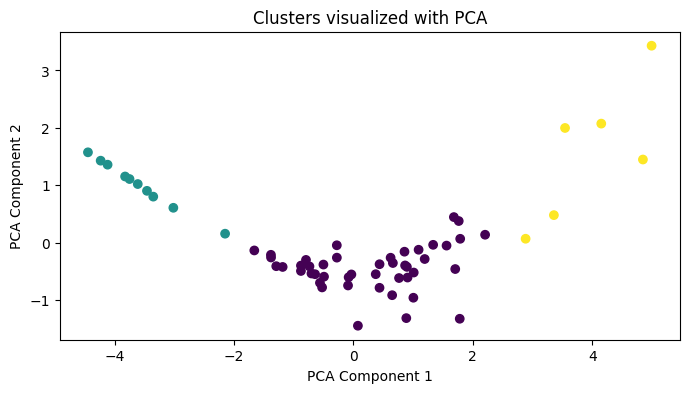

In [26]:
#https://medium.com/@a.cervantes2012/interpreting-and-validating-clustering-results-with-k-means-e98227183a4d
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X_pca = pca.fit_transform(Xs)
plt.figure(figsize=(8, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = labels, cmap = 'viridis')
plt.title("Clusters visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [27]:
state_features = state_numeric.copy()
state_features['cluster'] = labels
feature_cols = [c for c in state_features.columns if c not in ['Prscrbr_Geo_Cd', 'Prscrbr_Geo_Desc', 'top_drug', 'top_drug_cost_per_claim', 'total_claims', 'cluster']]
feature_cols = ['Average Cost Per Claim ($)' if x == 'avg_cost_per_claim' else x for x in feature_cols]
feature_cols = ['Median Cost Per Claim ($)' if x == 'median_cost_per_claim' else x for x in feature_cols]
feature_cols = ['Unique Drugs' if x == 'unique_drugs' else x for x in feature_cols]
feature_cols = ['Total Spend ($ Billions)' if x == 'total_spend' else x for x in feature_cols]
display_state_features = state_features.drop(columns = ['total_claims', 'Prscrbr_Geo_Desc', 'Prscrbr_Geo_Cd', 'top_drug', 'top_drug_cost_per_claim'])
display_state_features.rename(columns = {'avg_cost_per_claim': 'Average Cost Per Claim ($)', 'median_cost_per_claim': 'Median Cost Per Claim ($)', 'total_spend': 'Total Spend ($ Billions)', 'unique_drugs': 'Unique Drugs'}, inplace = True)
display(display_state_features.groupby('cluster')[feature_cols].median().round(2))


,Average Cost Per Claim ($),Median Cost Per Claim ($),Total Spend ($ Billions),Unique Drugs
cluster,,,,
0,1911.44,215.09,1.516171e+10,1535.0
1,246.34,33.60,2.924288e+07,475.5
2,2364.43,288.24,1.025323e+11,1905.5


In [28]:
from dash import Dash, html
import dash_ag_grid as dag

# # Initialize Dash app
# app = Dash(__name__)

# column_defs = [{'headerName': col, 'field': col, 'resizable': True, 'flex': 1} for col in display_state_features.columns]
# display_state_features['Total Spend ($ Billions)'] = display_state_features['Total Spend ($ Billions)'].apply(lambda x: x / 1000000000)

# rowData = display_state_features.groupby('cluster')[feature_cols].median().round(2)
# rowData = rowData.reset_index()
# display(rowData)
# # Create AG-Grid
# grid = dag.AgGrid(
#     columnDefs = column_defs,
#     rowData = rowData.to_dict('records'),
#     defaultColDef = {"resizable": True},  # Enable resizing for all columns by default
#     style = {"height": "300px", "width": "100%"},
# )

# app.layout = html.Div([grid])

# if __name__ == "__main__":
#     app.run(debug = True)

In [29]:
import plotly.express as px
import plotly.graph_objects as go

def plot_brand_spending(brand_name, annotate_anda=True):
    sub = brand_spend_with_anda.loc[brand_spend_with_anda['Brnd_Name'].eq(brand_name)].copy()
    if sub.empty:
        print("No data for:", brand_name)
        return
    
    fig = px.line(sub, x='year', y='spend', markers=True, title=f"Total Spending — {brand_name}")
    
    if annotate_anda and sub['first_anda_year'].notna().any():
        anda_year = int(sub['first_anda_year'].dropna().iloc[0])
        fig.add_vline(x=anda_year, line_width=2, line_dash="dash")
        fig.add_annotation(x=anda_year, y=sub['spend'].max(), text=f"First ANDA: {anda_year}",
                           showarrow=True, yshift=30)
    fig.update_layout(xaxis_title="Year", yaxis_title="Total Spending", width = 800, height = 800)
    fig.show()

plot_brand_spending("Crestor")

In [30]:
import plotly.express as px
import plotly.graph_objects as go

def plot_brand_spending(brand_name, annotate_anda=True):
    sub = brand_spend_with_anda.loc[brand_spend_with_anda['Brnd_Name'].eq(brand_name)].copy()
    if sub.empty:
        print("No data for:", brand_name)
        return
    
    fig = px.line(sub, x='year', y='spend', markers=True, title=f"Total Spending — {brand_name}")
    
    if annotate_anda and sub['first_anda_year'].notna().any():
        anda_year = int(sub['first_anda_year'].dropna().iloc[0])
        fig.add_vline(x=anda_year, line_width=2, line_dash="dash")
        fig.add_annotation(x=anda_year, y=sub['spend'].max(), text=f"First ANDA: {anda_year}",
                           showarrow=True, yshift=30)
    fig.update_layout(xaxis_title="Year", yaxis_title="Total Spending", width = 800, height = 800)
    fig.show()

plot_brand_spending("Lipitor")

In [31]:
import plotly.graph_objects as go

def plot_brand_spending(brand_name, other_cols=None, annotate_anda=True):
    if other_cols is None:
        other_cols = ['dosage_units', 'claims', 'avg_spend_per_claim']
    
    sub = brand_spend_with_anda.loc[brand_spend_with_anda['Brnd_Name'].eq(brand_name)].copy()
    if sub.empty:
        print("No data for:", brand_name)
        return
    sub = sub.sort_values('year')

    # --- figure 1: spend only ---
    fig1 = go.Figure()
    fig1.add_trace(
        go.Scatter(
            x=sub['year'],
            y=sub['spend'],
            mode='lines+markers',
            name='spend'
        )
    )
    if annotate_anda and sub['first_anda_year'].notna().any():
        anda_year = int(sub['first_anda_year'].dropna().iloc[0])
        fig1.add_vline(x=anda_year, line_width=2, line_dash="dash")
        fig1.add_annotation(
            x=anda_year,
            y=sub['spend'].max(),
            text=f"First ANDA: {anda_year}",
            showarrow=True,
            yshift=30
        )
    fig1.update_layout(
        title=f"Spending — {brand_name}",
        xaxis_title="Year",
        yaxis_title="Total Spending",
        height = 800,
        width = 1200
    )
    fig1.show()

    # --- figure 2: other columns (smaller scale) ---
    fig2 = go.Figure()
    for col in other_cols:
        if col in sub.columns:
            fig2.add_trace(
                go.Scatter(
                    x=sub['year'],
                    y=sub[col],
                    mode='lines+markers',
                    name=col
                )
            )
    fig2.update_layout(
        title=f"Other metrics — {brand_name}",
        xaxis_title="Year",
        yaxis_title="Value",
        height = 800,
        width = 1200
    )
    fig2.show()

# Example:
# plot_brand_spending("Cymbalta")
plot_brand_spending("Crestor", other_cols=['claims','dosage_units', 'avg_spend_per_claim'])


In [32]:
import plotly.graph_objects as go

def plot_brand_spending(
    brand_name,
    other_cols=None,      # very small / misc
    mid_cols=None,        # 1,000 to 1,000,000 type cols
    annotate_anda=True
):
    if other_cols is None:
        other_cols = ['avg_spend_per_claim']
    if mid_cols is None:
        mid_cols = ['dosage_units', 'claims']  # set your own later, e.g. ['some_mid_metric']

    sub = brand_spend_with_anda.loc[brand_spend_with_anda['Brnd_Name'].eq(brand_name)].copy()
    if sub.empty:
        print("No data for:", brand_name)
        return
    sub = sub.sort_values('year')

    # --- figure 1: spend only ---
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=sub['year'], y=sub['spend'], mode='lines+markers', name='spend'))
    if annotate_anda and sub['first_anda_year'].notna().any():
        anda_year = int(sub['first_anda_year'].dropna().iloc[0])
        fig1.add_vline(x=anda_year, line_width=2, line_dash="dash")
        fig1.add_annotation(x=anda_year, y=sub['spend'].max(),
                            text=f"First ANDA: {anda_year}", showarrow=True, yshift=30)
    fig1.update_layout(title=f"Spending — {brand_name}", xaxis_title="Year", yaxis_title="Total Spending")
    fig1.show()

    # --- figure 2: other (small) ---
    fig2 = go.Figure()
    for col in other_cols:
        if col in sub.columns:
            fig2.add_trace(go.Scatter(x=sub['year'], y=sub[col], mode='lines+markers', name=col))
    fig2.update_layout(title=f"Other metrics — {other_cols[0]} {brand_name}", xaxis_title="Year", yaxis_title="Value")
    fig2.show()

    # --- figure 3: mid-size ---
    if mid_cols:
        fig3 = go.Figure()
        for col in mid_cols:
            if col in sub.columns:
                fig3.add_trace(go.Scatter(x=sub['year'], y=sub[col], mode='lines+markers', name=col))
        fig3.update_layout(title=f"Mid-size metrics — {brand_name}", xaxis_title="Year", yaxis_title="Value")
        fig3.show()

# example:
plot_brand_spending("Crestor", mid_cols=['claims'])


In [33]:
import geopandas as gpd
import json
geojson_path_for_state_cluster = "us_states.json"
# geojson_path = gpd.read_file("us_states.json") 
geojson_path = "us_states.json"

In [34]:
PATENT_CLIFF_BRANDS = [
    "LIPITOR",
    "PLAVIX",
    "SINGULAIR",
    "HUMIRA",
    "CRESTOR",
    "LANTUS",
    "ADVAIR DISKUS",
    # "ADVAIL HFA",
    # ...
]

drug = "CRESTOR"

d = dataframes_copy.copy()
d["Prscrbr_Geo_Cd"] = d["Prscrbr_Geo_Cd"].astype(str).str.zfill(2)
d["Brnd_Name"] = d["Brnd_Name"].str.upper()
d["Gnrc_Name"] = d["Gnrc_Name"].str.upper()

# brand rows
br = d[d["Brnd_Name"] == drug]

# get the matching generic name from brand rows
generic = br["Gnrc_Name"].dropna().unique()
generic = generic[0] if len(generic) else None

gn = d[d["Gnrc_Name"] == generic] if generic else d.iloc[0:0]

# brand: group by year + state
brand_agg = (
    br.groupby(["year","Prscrbr_Geo_Cd","Prscrbr_Geo_Desc"], as_index=False)
      .agg(
          brand_cost=("Tot_Drug_Cst","sum"),
          brand_clms=("Tot_Clms","sum"),
      )
)

# generic: group by year + state
gen_agg = (
    gn.groupby(["year","Prscrbr_Geo_Cd","Prscrbr_Geo_Desc"], as_index=False)
      .agg(
          gen_cost=("Tot_Drug_Cst","sum"),
          gen_clms=("Tot_Clms","sum"),
      )
)

merged = brand_agg.merge(
    gen_agg, on=["year","Prscrbr_Geo_Cd","Prscrbr_Geo_Desc"], how="outer"
).fillna(0)
merged[merged['Prscrbr_Geo_Desc'] == 'Wisconsin']

,year,Prscrbr_Geo_Cd,Prscrbr_Geo_Desc,brand_cost,brand_clms,gen_cost,gen_clms
49,2017,55,Wisconsin,3363026.71,8156.0,11319775.90,134230
109,2018,55,Wisconsin,974298.80,2245.0,7960870.09,158701
170,2019,55,Wisconsin,765805.11,1601.0,9647106.97,191974
230,2020,55,Wisconsin,722061.64,1375.0,7954201.95,235709
290,2021,55,Wisconsin,646345.46,1166.0,8174573.99,281740
350,2022,55,Wisconsin,578438.53,952.0,8476796.73,345241
411,2023,55,Wisconsin,509422.38,852.0,9210374.63,423978


In [35]:
# avoid divide by zero
merged["brand_cpc"] = np.where(
    merged["brand_clms"] > 0,
    merged["brand_cost"] / merged["brand_clms"],
    np.nan,
)
merged["gen_cpc"] = np.where(
    merged["gen_clms"] > 0,
    merged["gen_cost"] / merged["gen_clms"],
    np.nan,
)

# 1) pure price effect
merged["price_gap"] = merged["brand_cpc"] - merged["gen_cpc"]

# 2) adoption
merged["total_pair_clms"] = merged["brand_clms"] + merged["gen_clms"]
merged["brand_share"] = np.where(
    merged["total_pair_clms"] > 0,
    merged["brand_clms"] / merged["total_pair_clms"],
    np.nan,
)
merged[merged['Prscrbr_Geo_Desc'] == 'Wyoming']

,year,Prscrbr_Geo_Cd,Prscrbr_Geo_Desc,brand_cost,brand_clms,gen_cost,gen_clms,brand_cpc,gen_cpc,price_gap,total_pair_clms,brand_share
50,2017,56,Wyoming,183782.91,417.0,629156.79,8049,440.726403,78.165833,362.560570,8466.0,0.049256
110,2018,56,Wyoming,39943.93,91.0,493827.04,9668,438.944286,51.078511,387.865775,9759.0,0.009325
171,2019,56,Wyoming,45439.34,91.0,591598.84,10951,499.333407,54.022358,445.311049,11042.0,0.008241
231,2020,56,Wyoming,41720.67,72.0,550098.38,12981,579.453750,42.377196,537.076554,13053.0,0.005516
291,2021,56,Wyoming,35561.94,64.0,521490.52,14887,555.655313,35.029927,520.625386,14951.0,0.004281
351,2022,56,Wyoming,26065.68,37.0,554857.86,17069,704.477838,32.506758,671.971079,17106.0,0.002163
412,2023,56,Wyoming,21158.36,29.0,468629.84,21343,729.598621,21.957074,707.641546,21372.0,0.001357


In [36]:
def plot_state_metric_from_merged(mdf, year, col, title):
    year_df = mdf[mdf["year"] == year].copy()
    with open(geojson_path, "r") as f:
        gj = json.load(f)

    # tighten to actual min/max so color matches hover
    vmin = year_df[col].min()
    vmax = year_df[col].max()

    fig = px.choropleth(
        year_df,
        geojson=gj,
        locations="Prscrbr_Geo_Cd",
        featureidkey="id",
        color=col,
        color_continuous_scale="YlOrRd",
        range_color=(vmin, vmax),
        labels={col: title},
        title=title,
        projection="natural earth"
    )
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_traces(
        hovertemplate="<b>%{customdata[0]}</b><br>" +
                      title + ": %{z:.3f}<extra></extra>",
        customdata=year_df[["Prscrbr_Geo_Desc"]].to_numpy()
    )
    fig.update_layout(width = 1200, height = 600, coloraxis_colorbar=dict(
        len=0.7,          # shorter bar (0–1)
        thickness=12,     # thinner
        y=0.7,            # center vertically
        yanchor="middle",
    ),)
    return fig

In [37]:
# price gap, adjust year as necessary
fig_price_year = plot_state_metric_from_merged(
    merged,
    year=2023,
    col="price_gap",
    title="Crestor Price Gap (Brand - Generic) in 2023"
)
fig_price_year.show()

In [ ]:
# used this for the choropleth as I could adjust the output size. Doesn't look as good as forium but more practical
fig = px.choropleth(clustered, geojson=geojson_path_for_state_cluster, locations='Prscrbr_Geo_Cd', color='cluster',
                           color_continuous_scale="Viridis",
                           range_color=(0, 2),
                           scope="usa",
                           labels={'cluster': 'cluster'}
                          )
fig.update_layout(
    width = 1600,
    height = 1200,
    legend = dict(
        font = dict(size = 256),
        title = dict(font = dict(size = 48))
    ),
    margin={"r":0,"t":0,"l":0,"b":0})
legend=dict(font=dict(size=12))  # Change legend font size
fig.show()
